In [13]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score
import numpy as np
import itertools
from itertools import permutations, combinations
import time
from pylab import *

torch.manual_seed(1)                      # reproducible
torch.set_printoptions(threshold=np.inf)  # print all

def findByRow(mat, row):
    return np.where((mat == row).all(1))[0]


# ----- Step 1: Set Hyper Parameters ----- #

NAME = 'CNN-MNIST'
OUTPUT_CLASS = 10

RELEASE_LISTS = [
    [2,3],
    [3,2]
]
RELEASE_FACTOR = 0.1

LR = 0.01
BATCH_SIZE = 64

TURNS = 150

K = 3
T = 20

K_release = K-1
T_max = T-1


# ----- Step 2: Load MNIST Dataset and Create Loader ----- #

train_data = dsets.MNIST(root='../Datasets', train=True, transform=transforms.ToTensor(), download=True)
test_data = dsets.MNIST(root='../Datasets', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

train_X = train_data.train_data.type(torch.FloatTensor)/255.
train_Y = train_data.train_labels.numpy()
test_X = test_data.test_data.type(torch.FloatTensor)/255.
test_Y = test_data.test_labels.numpy()

train_Y1 = train_data.train_labels.type(torch.LongTensor)


# ----- Step 3: Create Model Class ----- #

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(1,16,kernel_size=3,stride=1,padding=1)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16,32,kernel_size=3,stride=1,padding=1)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(32*7*7,16)#两个池化，所以是7*7而不是14*14
        self.fc2 = nn.Linear(16,10)

    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7* 7)#将数据平整为一维的 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  
        return x


# ----- Step 4: Instantiate ----- #

model = CNN()
print(model)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

MS_loss_fn = torch.nn.MSELoss()


# ----- Step 5: Model Training ----- #

turns_record = []
loss_record = []
MS_loss_record = []
train_acc_record = []
F1_record = []
MCC_record = []
Score_record = []

total_loss_time = 0
total_MS_loss_time = 0
total_acc_time = 0
total_F1_time = 0
total_MCC_time = 0
total_Score_time = 0          

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

train_x_tensor = None
train_y_tensor = None
for batch_idx, data in enumerate(train_loader, 0):
    if batch_idx > 100:
        break
    inputs, target = data[0].to(device), data[1].to(device)
    if train_x_tensor == None:
        train_x_tensor = inputs
        train_y_tensor = target
    else:
        train_x_tensor = torch.cat([train_x_tensor, inputs], dim=0)
        train_y_tensor = torch.cat([train_y_tensor, target], dim=0) 
    
train_y_npy = train_y_tensor.numpy()
y_train_onehot = torch.nn.functional.one_hot(train_y_tensor)

turns_index = 0
for turns in range(1, 6):
    if turns_index >= 150:
            break
            
    for batch_idx, data in enumerate(train_loader, 0):
        inputs, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()  # clear gradients for this training step
        outputs = model(inputs)
        loss = loss_fn(outputs, target)
        loss.backward()        # backward and compute gradients
        optimizer.step()       # apply gradients
    
        if batch_idx % 5 == 0:
            turns_index += 1
            if turns_index >= 150:
                break
            
            # Shared Part - train_output
            SP_trainout_time_part_start = time.time()
            train_output = model(train_x_tensor)
            SP_trainout_time_part_stop = time.time()

            # Shared Part - softmax
            SP_softmax_time_part_start = time.time()
            train_output_result = F.softmax(train_output, dim=1)  # softmax in last dim
            SP_softmax_time_part_stop = time.time()

            # Shared Part - pred_train_y
            SP_predy_time_part_start = time.time()
            pred_train_y = torch.max(train_output, 1)[1].data.numpy()
            SP_predy_time_part_stop = time.time()

            # Acc
            acc_time_part_start = time.time()
            train_accuracy = float((pred_train_y == train_y_npy).astype(int).sum()) / float(train_y_npy.size)
            acc_time_part_stop = time.time()

            # MS Loss
            MS_loss_time_part_start = time.time()
            MS_train_loss = MS_loss_fn(train_output_result, y_train_onehot)
            MS_loss_time_part_stop = time.time()

            # CE Loss
            loss_time_part_start = time.time()
            train_loss = loss_fn(train_output, train_y_tensor)
            loss_time_part_stop = time.time()

            # F1
            F1_time_part_start = time.time()
            F1 = f1_score(train_y_npy, pred_train_y, average='macro')
            F1_time_part_stop = time.time()

            # MCC
            MCC_time_part_start = time.time()
            MCC = matthews_corrcoef(train_y_npy, pred_train_y)
            MCC_time_part_stop = time.time()

            # Score
            Score_time_part_start = time.time()
            output_results = train_output_result.detach().numpy()
            prediction_pattern = np.argsort(-output_results)[:, :K]  # sorted_states_index
            confidence_pattern = T_max - np.floor((-np.sort(-output_results)[:, :K]) * T)  # sorted_states_t
            confidence_pattern[confidence_pattern == -1] = 0

            total_score = 0
            pattern_num = len(confidence_pattern)
            release_factors = np.ones((pattern_num, K))

            for i in range(pattern_num):
                current_prediction_pattern = list(prediction_pattern[i])
                if train_y_npy[i] in current_prediction_pattern:
                    correct_index = current_prediction_pattern.index(train_y_npy[i])
                    confidence_pattern[i][correct_index] = T_max - confidence_pattern[i][correct_index]
                    release_factors[i][correct_index] = K_release

                    for release_list in RELEASE_LISTS:
                        if current_prediction_pattern[correct_index] == release_list[0]:
                            for j in range(K):
                                if j != correct_index and current_prediction_pattern[j] in release_list[1:]:
                                    release_factors[i][j] = RELEASE_FACTOR

            release_factors /= release_factors.sum(axis=1).reshape(-1,1)
            confidence_pattern[confidence_pattern == 0] = 1e-7
            confidence_pattern = -np.log(confidence_pattern / T_max)
            total_score = (np.multiply(release_factors, confidence_pattern).sum()) / pattern_num
            Score_time_part_stop = time.time()

            # (Test Acc)
#             test_output = model(test_X)
#             pred_test_y = torch.max(test_output, 1)[1].data.numpy()
#             test_accuracy = float((pred_test_y == test_Y).astype(int).sum()) / float(test_Y.size)

            print('TURNS ID: ', turns_index, '| Acc: %.4f' % train_accuracy, '| F1: %.4f' % F1, '| MCC: %.4f' % MCC, 
                  '| MS Loss: %.4f' % MS_train_loss.data.numpy(), '| CE Loss: %.4f' % train_loss.data.numpy(), 
                  '| Score: %.4f' % total_score)  # , '| Test: %.4f' % test_accuracy)

            turns_record.append(turns_index)
            loss_record.append(train_loss.data.numpy())
            MS_loss_record.append(MS_train_loss.data.numpy())
            train_acc_record.append(train_accuracy)
            F1_record.append(F1)
            MCC_record.append(MCC)
            Score_record.append(total_score)

            SP_softmax_time = (SP_softmax_time_part_stop - SP_softmax_time_part_start)
            SP_predy_time = (SP_predy_time_part_stop - SP_predy_time_part_start)
            SP_trainout_time = (SP_trainout_time_part_stop - SP_trainout_time_part_start)

            total_loss_time += ((loss_time_part_stop - loss_time_part_start) + SP_trainout_time)
            total_MS_loss_time += ((MS_loss_time_part_stop - MS_loss_time_part_start) + SP_trainout_time + SP_softmax_time)
            total_acc_time += ((acc_time_part_stop - acc_time_part_start) + SP_predy_time + SP_trainout_time)
            total_F1_time += ((F1_time_part_stop - F1_time_part_start) + SP_predy_time + SP_trainout_time)
            total_MCC_time += ((MCC_time_part_stop - MCC_time_part_start) + SP_predy_time + SP_trainout_time)
            total_Score_time += ((Score_time_part_stop - Score_time_part_start) + SP_softmax_time + SP_trainout_time)

print('\nAverage Time Cost: ', '\nAcc: %.8f' % (total_acc_time/TURNS), '\nF1: %.8f' % (total_F1_time/TURNS), 
      '\nMCC: %.8f' % (total_MCC_time/TURNS), '\nMS Loss: %.8f' % (total_MS_loss_time/TURNS), 
      '\nCE Loss: %.8f' % (total_loss_time/TURNS), '\nScore: %.8f' % (total_Score_time/TURNS))      


C:\Users\thinkpad\AppData\Roaming\Python\Python38\site-packages\torchvision\datasets\mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\thinkpad\AppData\Roaming\Python\Python38\site-packages\torchvision\datasets\mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
C:\Users\thinkpad\AppData\Roaming\Python\Python38\site-packages\torchvision\datasets\mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\thinkpad\AppData\Roaming\Python\Python38\site-packages\torchvision\datasets\mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=10, bias=True)
)


D:\Download\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


TURNS ID:  1 | Acc: 0.0992 | F1: 0.0180 | MCC: 0.0000 | MS Loss: 0.0904 | CE Loss: 2.3298 | Score: 0.4401
TURNS ID:  2 | Acc: 0.3359 | F1: 0.2610 | MCC: 0.2876 | MS Loss: 0.0860 | CE Loss: 2.1336 | Score: 0.7972
TURNS ID:  3 | Acc: 0.4759 | F1: 0.4280 | MCC: 0.4353 | MS Loss: 0.0725 | CE Loss: 1.6409 | Score: 0.7453
TURNS ID:  4 | Acc: 0.6176 | F1: 0.5946 | MCC: 0.5847 | MS Loss: 0.0547 | CE Loss: 1.2171 | Score: 0.5720
TURNS ID:  5 | Acc: 0.6830 | F1: 0.6688 | MCC: 0.6523 | MS Loss: 0.0450 | CE Loss: 0.9825 | Score: 0.5154
TURNS ID:  6 | Acc: 0.7367 | F1: 0.7255 | MCC: 0.7099 | MS Loss: 0.0377 | CE Loss: 0.8128 | Score: 0.4397
TURNS ID:  7 | Acc: 0.7782 | F1: 0.7748 | MCC: 0.7551 | MS Loss: 0.0325 | CE Loss: 0.6992 | Score: 0.4400
TURNS ID:  8 | Acc: 0.8244 | F1: 0.8218 | MCC: 0.8062 | MS Loss: 0.0257 | CE Loss: 0.5671 | Score: 0.3543
TURNS ID:  9 | Acc: 0.8281 | F1: 0.8256 | MCC: 0.8103 | MS Loss: 0.0256 | CE Loss: 0.5589 | Score: 0.4085
TURNS ID:  10 | Acc: 0.8526 | F1: 0.8517 | MCC

TURNS ID:  78 | Acc: 0.9615 | F1: 0.9615 | MCC: 0.9572 | MS Loss: 0.0055 | CE Loss: 0.1196 | Score: 0.1018
TURNS ID:  79 | Acc: 0.9635 | F1: 0.9634 | MCC: 0.9595 | MS Loss: 0.0057 | CE Loss: 0.1270 | Score: 0.1068
TURNS ID:  80 | Acc: 0.9616 | F1: 0.9617 | MCC: 0.9575 | MS Loss: 0.0060 | CE Loss: 0.1357 | Score: 0.1136
TURNS ID:  81 | Acc: 0.9669 | F1: 0.9668 | MCC: 0.9632 | MS Loss: 0.0050 | CE Loss: 0.1161 | Score: 0.0959
TURNS ID:  82 | Acc: 0.9606 | F1: 0.9602 | MCC: 0.9562 | MS Loss: 0.0061 | CE Loss: 0.1324 | Score: 0.1243
TURNS ID:  83 | Acc: 0.9688 | F1: 0.9685 | MCC: 0.9653 | MS Loss: 0.0048 | CE Loss: 0.1076 | Score: 0.0943
TURNS ID:  84 | Acc: 0.9674 | F1: 0.9673 | MCC: 0.9638 | MS Loss: 0.0050 | CE Loss: 0.1131 | Score: 0.0906
TURNS ID:  85 | Acc: 0.9570 | F1: 0.9571 | MCC: 0.9524 | MS Loss: 0.0066 | CE Loss: 0.1483 | Score: 0.1544
TURNS ID:  86 | Acc: 0.9624 | F1: 0.9623 | MCC: 0.9584 | MS Loss: 0.0058 | CE Loss: 0.1278 | Score: 0.1347
TURNS ID:  87 | Acc: 0.9610 | F1: 0.9

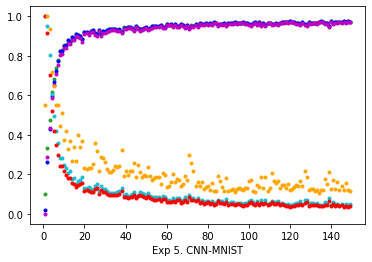

In [14]:
# loss 归一化
max_loss = 0
max_MS_loss = 0
max_train_acc = 0
max_F1 = 0
max_MCC = 0
max_Score = 0

for i in range(len(turns_record)):
    if loss_record[i] > max_loss:
        max_loss = loss_record[i]
    if MS_loss_record[i] > max_MS_loss:
        max_MS_loss = MS_loss_record[i]
    if Score_record[i] > max_Score:
        max_Score = Score_record[i]    

for i in range(len(loss_record)):
    loss_record[i] = loss_record[i]/max_loss
    MS_loss_record[i] = MS_loss_record[i]/max_MS_loss
    Score_record[i] = Score_record[i]/max_Score
    
plt.plot(turns_record, train_acc_record, '.', color = 'tab:green', label='ACC')
plt.plot(turns_record, F1_record, '.', color = 'b', label='F1') # lightpink
plt.plot(turns_record, MCC_record, '.', color = 'm', label='MCC')
plt.plot(turns_record, MS_loss_record, '.', color = 'tab:cyan', label='MS') # turquoise
plt.plot(turns_record, loss_record, '.', color = 'r', label='CE') # blueviolet
plt.plot(turns_record, Score_record, '.', color = 'orange', label='MPWS')

# plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

LABEL = 'Exp 5'
plt.xlabel(f"{LABEL}. {NAME}")

plt.savefig(f'../Savefig/{LABEL}.png', bbox_inches='tight', dpi=600)  # 保存该图片
plt.show()

In [15]:
import pandas as pd

train_acc_record_df = pd.DataFrame(train_acc_record)
F1_record_df = pd.DataFrame(F1_record)
MCC_record_df = pd.DataFrame(MCC_record)
MS_loss_record_df = pd.DataFrame(MS_loss_record)
loss_record_df = pd.DataFrame(loss_record)
Score_record_df = pd.DataFrame(Score_record)

data_df = pd.concat([train_acc_record_df, F1_record_df, MCC_record_df, MS_loss_record_df, loss_record_df, Score_record_df], axis=1)
data_df.columns = ['Accuracy', 'F1-score', 'MCC', 'Mean Squared', 'Cross Entropy', 'MPWS']  # head

writer = pd.ExcelWriter(f"../Records/{LABEL}. {NAME}.xlsx")
data_df.to_excel(writer,'page_1')
writer.save()

